# CS 6476 Assignment 2 | Part 3: Transfer Learning with ResNet-18

## Introduction

So far we have looked at using linear models or shallow CNNs to classify images. These models have been somewhat successful, but modern deep neural networks do outperform the previous models by a large margin.

The catch is that we would need to train the large model on our data for many epochs to achieve decent performance, which is computationally expensive. Enter transfer learning!



### Aim

We will "fine-tune" a pretrained ResNet-18 model on CIFAR-10. We will change the final classifier layer in the model and train it on CIFAR-10 dataset.

### Assignment requirement

This part of the assignment will make use of the GPU. Please make sure to use the GPU in Colab. This notebook will require around 15 minutes to execute end-to-end.

Turn on GPU: Click on "Runtime" -> "Change runtime type" -> Choose "T4 GPU" under "Hardware accelerator" -> Click "Save" -> Your runtime will restart with the GPU enabled.

### Grading and submission

You will need to add your code in the following sections:
- Model definition -- changing final layer
- Model training -- hyperparameters

Please submit the final trained model file, "resnet.pth" to Gradescope along with your other ".py" files from the earlier sections.

**You will be graded on the basis of your model's accuracy on a hidden split of data.**

### What is transfer learning?

Transfer learning allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

In transfer learning, the knowledge of an already trained machine learning model is applied to a different but related problem. With transfer learning, we basically try to exploit what has been learned in one task to improve generalization in another. We transfer the weights that a network has learned at “task A” to a new “task B.”

The general idea is to use the knowledge a model has learned from a task with a lot of available labeled training data in a new task that doesn't have much data. Instead of starting the learning process from scratch, we start with patterns learned from solving a related task.

### Fine-tuning

Here is a typical workflow of transfer learning:

1. Take layers from a previously trained model.
2. Add some new layers on top of the pretrained layers. They will learn to turn the old features into predictions on a new dataset.
3. Train the new layers on your dataset.

In our case, we will use a ResNet-18 trained on the ImageNet-1k dataset containing around 1.3 million labelled images. We will train the final classifier on CIFAR-10.

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['convolutional_networks.py', 'fully_connected_networks.py', 'a2_helper.py', 'fully_connected_networks.ipynb', 'cs6476', 'convolutional_networks.ipynb']
```

In [2]:
import os
from pathlib import Path

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a CV2023 folder and put all the files under A2 folder, then 'CV2023/A2'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None #enter file name as the above example
# GOOGLE_DRIVE_PATH = os.path.join('/content','drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

# GOOGLE_DRIVE_PATH = "C:\Users\jaewo\Documents\GitHub\CS6476_Assignment2"
GOOGLE_DRIVE_PATH = Path(r"C:/Users/jaewo/Documents/GitHub/CS6476_Assignment2")

print(os.listdir(GOOGLE_DRIVE_PATH))

['.git', '.gitignore', 'a2_helper.py', 'cifar-10-batches-py', 'cifar-10-python.tar.gz', 'convolutional_networks.ipynb', 'convolutional_networks.py', 'cs6476', 'CS6476_Assignment2.code-workspace', 'fcn_model.pth', 'final_threeconvnet.pth', 'fully_connected_networks.ipynb', 'fully_connected_networks.py', 'README.md', 'resnet.pth', 'simple_models.ipynb', 'simple_models.py', 'transfer_learning.ipynb', '__pycache__']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from convolutional_networks.py!
Hello from a2_helper.py!
```

as well as the last edit time for the file `convolutional_networks.py`.

In [3]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
# time.tzset()

from convolutional_networks import hello_convolutional_networks
hello_convolutional_networks()

from a2_helper import hello_helper
hello_helper()

convolutional_networks_path = os.path.join(GOOGLE_DRIVE_PATH, 'convolutional_networks.py')
convolutional_networks_edit_time = time.ctime(os.path.getmtime(convolutional_networks_path))
print('convolutional_networks.py last edited on %s' % convolutional_networks_edit_time)

Hello from convolutional_networks.py!
Hello from a2_helper.py!
convolutional_networks.py last edited on Mon Sep 25 21:08:26 2023


## Data loading and preprocessing


We will load the CIFAR-10, similar to the earlier part.

### Imports
Here we import some useful packages and increase the default figure size.

In [4]:
import cs6476
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import statistics
import random
import time
import math
%matplotlib inline

from cs6476 import reset_seed, Solver

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

It's necessary to use GPU for this part. Run this cell to make sure you are using a GPU.

In [5]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


### Load the CIFAR-10 dataset
We have loaded the relevant subsets of CIFAR-10 dataset in the following variables. Note that these are `torch.Tensor`s.

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels

In [6]:
# Invoke the above function to get our data.
cs6476.reset_seed(0)
data_dict = cs6476.data.preprocess_cifar10(cuda=False, dtype=torch.float64, flatten=False)
X_train = data_dict["X_train"]
y_train = data_dict["y_train"]
X_val = data_dict["X_val"]
y_val = data_dict["y_val"]
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)

Train data shape:  torch.Size([40000, 3, 32, 32])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3, 32, 32])
Validation labels shape:  torch.Size([10000])


### Creating Torch Datasets and DataLoader

Torch has provided utilities to make batching of data easier: `Dataset` and `DataLoader`. Here, since we have our images as `torch.Tensor`s, we will use an additional utility `TensorDataset`, which will initialize a Torch Dataset from our tensors.


We will then create their corresponding `DataLoader`s. These are iterable objects, which can be used to iterate over batches of dataset. We will use them to train the model on batches of data.



You can read more on `torch.utils.data.Dataset` [here](https://pytorch.org/docs/stable/data.html).

In [7]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=256, drop_last=True)

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=256, drop_last=True)

We will test the dataloaders by printing the shape of a single batch. Note that here the first dimension is the batch size. As a rule of thumb, a smaller batch size per compute device (i.e. per GPU) is considered better for optimization.

In [8]:
for train_example in train_dataloader:
    print("Training batch input size: ", train_example[0].shape)
    print("Training batch output size: ",train_example[1].shape)
    break

for val_example in val_dataloader:
    print("Validation batch input size: ", val_example[0].shape)
    print("Validation batch output size: ",val_example[1].shape)
    break

Training batch input size:  torch.Size([256, 3, 32, 32])
Training batch output size:  torch.Size([256])
Validation batch input size:  torch.Size([256, 3, 32, 32])
Validation batch output size:  torch.Size([256])


## Model loading and manipulation

In this section, we will load a pretrained ResNet-50 model from `torchvision` and we will replace the last `Linear` layer from the model.

See [this page](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html) for more details on the pretrained model.

We will replace the `fc` layer from the model and retrain it. Since `torch` is an Pythonic library, we can directly replace the linear layer like an object attribute.

In [9]:
def get_model():
    model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights(torchvision.models.ResNet18_Weights.IMAGENET1K_V1))
    ####################################################################
    # TODO: Replace the `fc` attribute with a `torch.nn.Linear` layer  #
    # with 512 input dimensions and 10 output dimensions.             #
    ####################################################################

    model.fc = torch.nn.Linear(512, 10)

    ######################################################################
    #                            END OF YOUR CODE                        #
    ######################################################################
    return model

Pro tip: you can print the model outline by just running the following cell!

In [10]:
model = get_model()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We will print the summary of the model using `torchsummary` module. We will be able to see the number of trainable weights.

In [11]:
from torchsummary import summary

summary(model, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [12]:
del model # delete the model object so it is not re-used by mistake

## Fine-tune the model

The outline of model training procedure is as follows:

1. Define hyperparameters -- learning rate and weight decay.
2. Initialize optimizer.
3. Initialize metrics lists.
4. Train the model for as many epochs as you wish.   
    a. Iterate over each batch in every epoch.   
    b. Calculate loss and update model parameters.   
    c. Calculate metrics on train and validation split and store them.


See [this page](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) to learn more about `AdamW` optimizer.


In [13]:
######################################################################
############################  TODO  ##################################
# Define the hyperparameters for training. Play around with them until
# you get the best model.
######################################################################

LEARNING_RATE = 0.001
EPOCHS = 10
WEIGHT_DECAY = 0.001

######################################################################
#                            END OF YOUR CODE                        #
######################################################################

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_model()
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = torch.nn.CrossEntropyLoss()

train_loss_epochwise = list()
val_loss_epochwise = list()

train_accuracy_epochwise = list()
val_accuracy_epochwise = list()

In [15]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

In [16]:
for epoch in range(EPOCHS):
    # Initialize lists for storing losses and outputs. We will use
    # these outputs to calculate accuracy.
    train_loss_batchwise = list()
    val_loss_batchwise = list()

    train_predicted_labels = list()
    val_predicted_labels = list()

    train_labels_list = list()
    val_labels_list = list()

    model.train() # run before training the model

    for images, labels in train_dataloader:
        images, labels = images.float().to(device), labels.to(device)
        outputs = model(images)

        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        train_predicted_labels.append(outputs.argmax(dim=-1).detach().cpu().numpy())
        train_labels_list.append(labels.cpu().numpy())

        train_loss_batchwise.append(loss.detach().cpu().item())

    train_acc = accuracy(np.concatenate(train_labels_list, axis=0), np.concatenate(train_predicted_labels, axis=0))
    train_loss = np.mean(train_loss_batchwise)

    train_accuracy_epochwise.append(train_acc)
    train_loss_epochwise.append(train_loss)

    model.eval() # run before evaluating the model

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.float().to(device), labels.to(device)
            outputs = model(images)

            loss = loss_fn(outputs, labels)

            val_predicted_labels.append(outputs.argmax(dim=-1).detach().cpu().numpy())
            val_loss_batchwise.append(loss.detach().cpu().item())
            val_labels_list.append(labels.cpu().numpy())


    val_acc = accuracy(np.concatenate(val_labels_list, axis=0), np.concatenate(val_predicted_labels, axis=0))
    val_loss = np.mean(val_loss_batchwise)

    val_accuracy_epochwise.append(val_acc)
    val_loss_epochwise.append(val_loss)

    print("#"*20, "Epoch: ", epoch)
    print("Train accuracy: ", train_acc)
    print("Validation accuracy: ", val_acc)

    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    print()

#################### Epoch:  0
Train accuracy:  0.6929837740384616
Validation accuracy:  0.7197516025641025
Train loss:  0.9030162355838678
Validation loss:  0.8327534794807434

#################### Epoch:  1
Train accuracy:  0.8157552083333334
Validation accuracy:  0.7676282051282052
Train loss:  0.5456267996476247
Validation loss:  0.6794926126797994

#################### Epoch:  2
Train accuracy:  0.8655098157051282
Validation accuracy:  0.7872596153846154
Train loss:  0.39892552430048966
Validation loss:  0.6356068108326349

#################### Epoch:  3
Train accuracy:  0.8958082932692307
Validation accuracy:  0.7927684294871795
Train loss:  0.30665640169993424
Validation loss:  0.6442609276527014

#################### Epoch:  4
Train accuracy:  0.9201722756410257
Validation accuracy:  0.8064903846153846
Train loss:  0.232195995365962
Validation loss:  0.6727877679543618

#################### Epoch:  5
Train accuracy:  0.9381260016025641
Validation accuracy:  0.8071915064102564
T

## Results visualization

We will visualize the train and validation metrics for the training run.

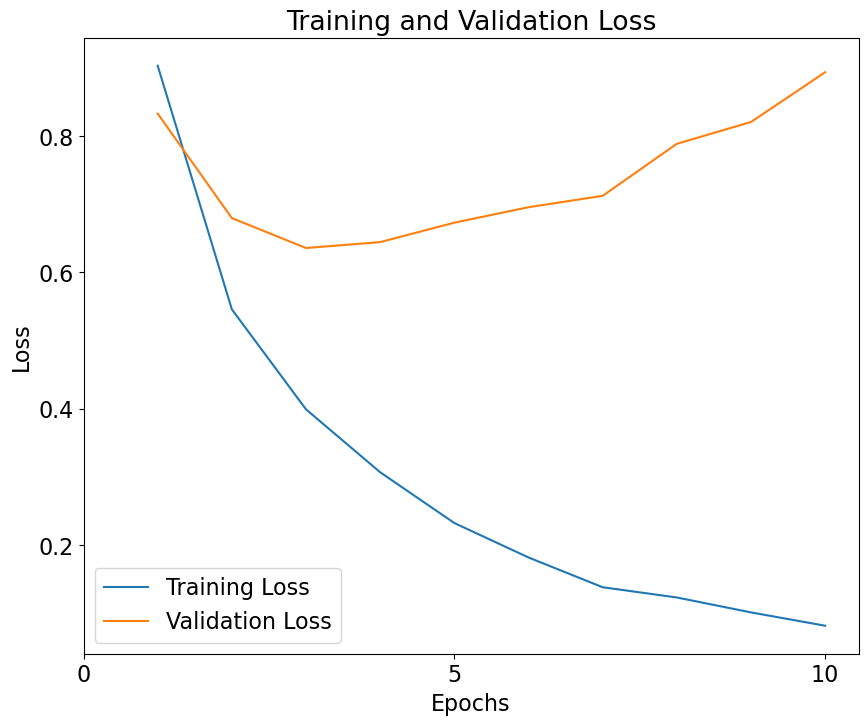

In [17]:
from matplotlib.pylab import plt
from numpy import arange

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, EPOCHS + 1)

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss_epochwise, label='Training Loss')
plt.plot(epochs, val_loss_epochwise, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, EPOCHS + 1, 5))

# Display the plot
plt.legend(loc='best')
plt.show()

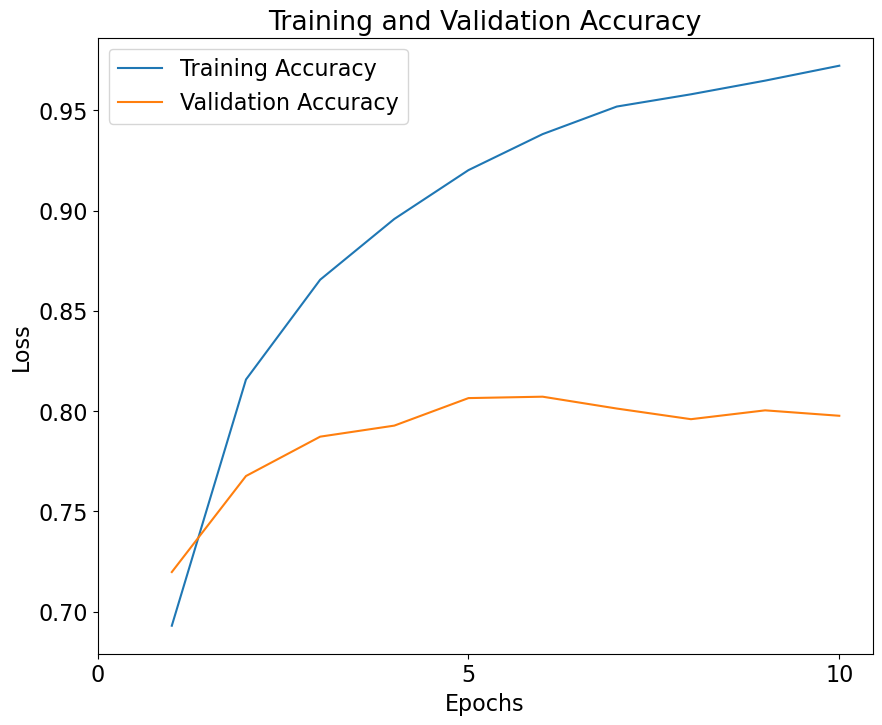

In [18]:
# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, EPOCHS + 1)

# Plot and label the training and validation loss values
plt.plot(epochs, train_accuracy_epochwise, label='Training Accuracy')
plt.plot(epochs, val_accuracy_epochwise, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, EPOCHS + 1, 5))

# Display the plot
plt.legend(loc='best')
plt.show()

### Create submission file

In [19]:
torch.save(model.state_dict(), "resnet.pth")

Upload this file to Gradescope along with other ".py" files.